# Projet BIML

Bonhoure Timothé 11931551 et Martinez Christophe 11709105

## Partie 1 : Perceptron

**Indiquer et expliquer la taille de chaque tenseur dans le fichier perceptron pytorch.py fourni.**

- $w$ est de taille $784 \times 10$. $784$ est le nombre de pixels dans chaque image ($28 \times 28$) et donc la taille de l'entrée et $10$ est la taille des vecteurs de label et de la sortie.  
- $b$ est de taille $1 \times 10$ car c'est le biais qui est de même dimension que la sortie.  
- $data\_train$ est de taille $784 \times nb\_data\_train$, $nb\_data\_train$ est le nombre d'images dans le set d'entrainement.  
- $data\_test$ est de taille $784 \times nb\_data\_test$, $nb\_data\_test$ est le nombre d'images dans le set de test.  
- $x$ est un batch de $data\_train$ ($784 \times batch\_size$)
- $y$ est la sortie associé au batch $x$ ($10 \times batch\_size$)
- $t$ est un batch des labels, associés à $x$ ($10 \times batch\_size$)
- $grad$ est le tenseur des gradient et est de même dimensions que $t$ et $y$

## Partie 2 : Shallow network

Implémentation de l’algorithme du perceptron multi-couches avec une seule couche cachée et une sortie linéaire.  
L'objectif est de trouver les hyper-paramètres $\eta$ et le nombre de neurones de la couche cachée ($N$).

### Méthodologie

```python
class ShallowNetwork(nn.Module):
	def __init__(self, N) -> None:
		super().__init__()
		self.linear1 = nn.Linear(784, N)
		nn.init.uniform_(self.linear1.weight, -0.001, 0.001)
		self.linear2 = nn.Linear(N, 10)
		nn.init.uniform_(self.linear2.weight, -0.001, 0.001)

	def forward(self, x):
		x = self.linear1(x)
		x = F.relu(x)
		return self.linear2(x)
```

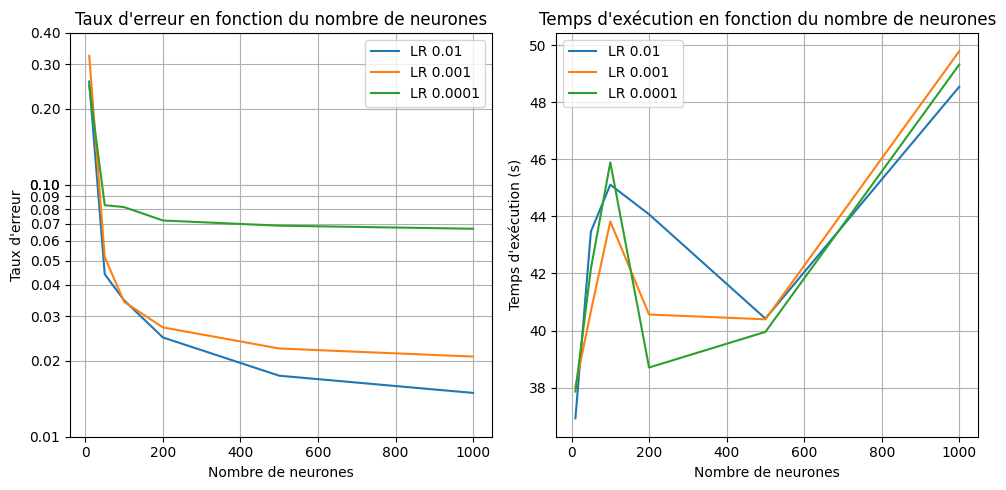

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Lire les données CSV
data = pd.read_csv('results_shallow.csv')

# Séparer les données en fonction du taux d'apprentissage
learning_rates = data['learning_rate'].unique()

# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Parcourir les taux d'apprentissage et créer les graphiques
for lr in learning_rates:
    subset = data[data['learning_rate'] == lr]
    ax1.plot(subset['number_of_neurones'], 1-subset['result'], label=f'LR {lr}')
    ax2.plot(subset['number_of_neurones'], subset['time'], label=f'LR {lr}')

# Configurer le premier graphique (Résultats)
ax1.set_xlabel('Nombre de neurones')
ax1.set_ylabel('Taux d\'erreur')
ax1.set_yscale("log")
yticks = [0.01 * i for i in range(1, 11)] + [0.1 * i for i in range(1, 5)]
ax1.set_yticks(yticks)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_title('Taux d\'erreur en fonction du nombre de neurones')
ax1.legend()
ax1.grid(True)

# Configurer le deuxième graphique (Temps d'exécution)
ax2.set_xlabel('Nombre de neurones')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.set_title('Temps d\'exécution en fonction du nombre de neurones')
ax2.legend()
ax2.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

### Influence des hyperparamètres

On observe que le nombre de neurones n'a plus d'effet sur le pourcentage de réussite du modèle à partir de 300 à 500 neurones. En revanche, le learning_rate est le paramètre qui a le plus d'effet globalement.  
En terme de temps d'exécution, on observe un pic que l'on ne saurait expliquer pour un nombre de neurones de 100. En dehors de cela, le nombre de neurones à une grande influence sur le temps d'exécution et ceci est cohérent car plus de neurones signifie plus de nombre de modification des poids. Les différents learning_rate sont globalement proche en terme de temps d'exécution mais diffèrent pour un nombre de neurones autours de 200.

Sur 1000 epochs, on voit d'après la courbe ci-dessus à gauche le meilleur résultat est obtenu avec un learning_rate est de 0.01 et pour un nombre de neurone de minimum 500. Or si on s'intéresse au temps d'apprentissage, pour un résultat assez proche et convenable : un learning_rate de 0.001 avec un nombre de neurones entre 200 et 500 est l'optimal.

## Partie 3 : Deep network

On cherche à déterminer les hyper-paramètres $\eta$, le nombre de couches ($N_C$), le nombre de neurones pour chaque couche ($N_i$ avec $i \in [\![1,N_C]\!]$) et la taille des batch ($batch\_size$).

### Méthodologie

Nous avons décidé de réaliser un grid-search sur l'ensemble des paramètres.

Nous avions tout d'abord décidé de limiter les choix des hyper-paramètres :
- $\eta \in \{0.01, 0.001, 0.0001\}$ 
- $N_C \in \{2,3,4\}$
- $\forall i \in [\![1,N_c]\!], \; N_i \in \{10, 50, 100\}$
- $batch\_size \in \{5,20,50\}$

Cependant cela créait trop de possibilité en effet rien que pour 4 couche cela créait $3^4 = 81$ possibilité de combinaison de taille des couches. Ainsi nous avons décidé de restreindre les possibilité pour réduire les temps de calcul. La première idée qu'on a eu fut d'avoir un facteur de décroissance. Nous avons donc décidé de prendre les valeurs possibles ci-dessous:

- $\eta \in \{0.01, 0.001, 0.0001\}$ 
- $N_C \in \{2,3,4\}$
- $q \in \{2, 3, 5\}$
- $batch\_size \in \{5,20,50\}$

Le set d'entrainement a été séparé en deux partir une première partie qui a servie d'entrainement aux modèles avec les différents paramètres et un deuxième plus petit (dit de validation) qui a servi à évaluer les performances des modèles pour déterminer le meilleure jeu de paramètre. Dans le tableau suivant a été rapporté la précision des modèles sur le set de validation et le temps qu'ils ont pris pour la phase d'apprentissage. 


![results_deep_incrementing_factor.png](img/results_deep_incrementing_factor.png)
Le meilleure jeu de paramètre à ensuite été évalué sur le set de test, il a eu une précision de `0.9871`.

Cependant en étudiant les temps et les précision des différents modèles nous avons remarqué que le temps d'apprentissage était fortement lié à la taille de la première couche (voir figure ci-dessous) et que cette valeur semblait aussi avoir un effet sur la précision. Ainsi nous avons décidé de garder la même forme avec une décroissance géométrique mais fixer la taille de la première couche au lieu du facteur de décroissance. Ce qui permettras d'avoir des modèles qui auront des temps plus facilement controlable.

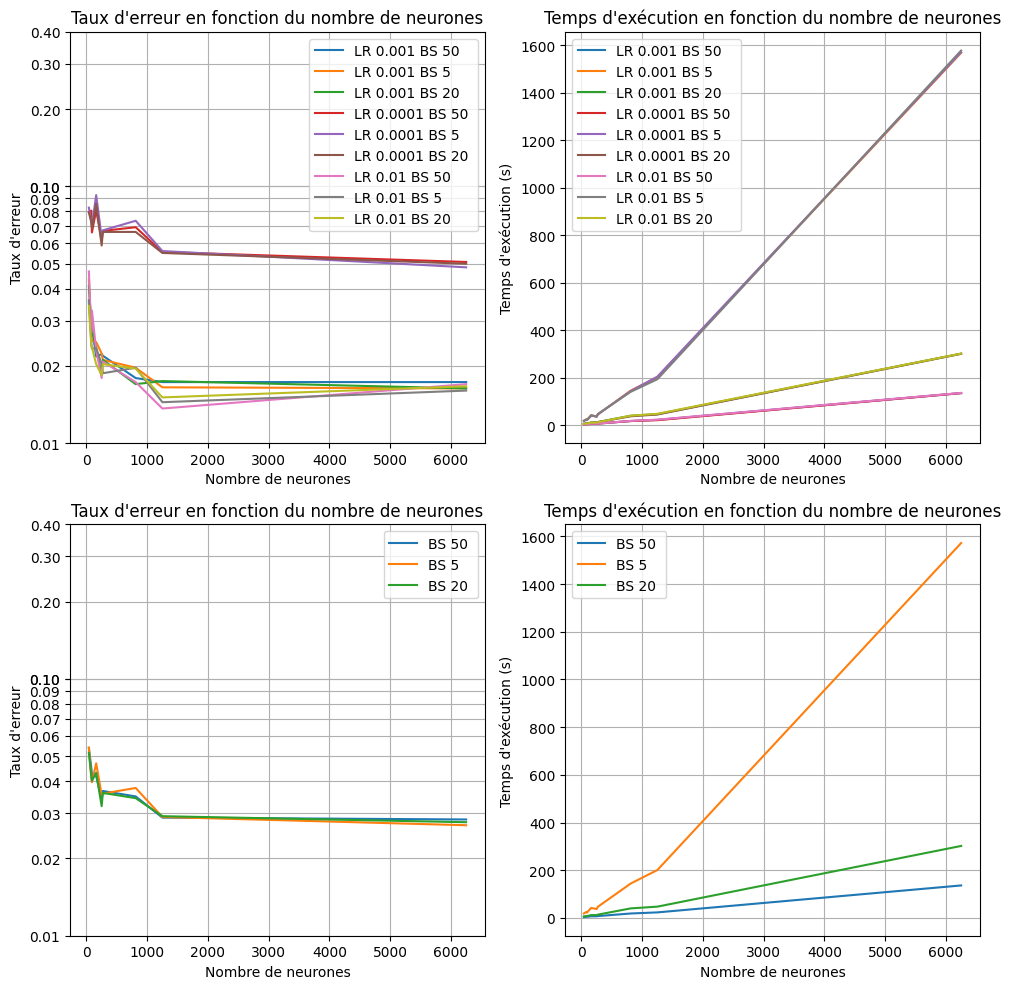

In [40]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product

# Lire les données CSV
data = pd.read_csv('results_deep_incrementing_factor.csv')
data["first_layer_size"] = 10 * data['incrementing_factor'] ** data['number_of_layers']
data = data.sort_values(["first_layer_size"])


# Séparer les données en fonction du taux d'apprentissage
learning_rates = data['learning_rate'].unique()
batch_sizes = data['batch_size'].unique()

# Créer une figure avec deux sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# Parcourir les taux d'apprentissage et créer les graphiques
for lr, bs in product(learning_rates, batch_sizes):
    subset = data[(data['learning_rate'] == lr) & (data['batch_size'] == bs)]
    ax1.plot(subset["first_layer_size"] , 1-subset['resultat'], label=f'LR {lr} BS {bs} ')
    ax2.plot(subset["first_layer_size"], subset['temps'], label=f'LR {lr} BS {bs} ')

# Configurer le premier graphique (Résultats)
ax1.set_xlabel('Nombre de neurones')
ax1.set_ylabel('Taux d\'erreur')
ax1.set_yscale("log")
yticks = [0.01 * i for i in range(1, 11)] + [0.1 * i for i in range(1, 5)]
ax1.set_yticks(yticks)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_title('Taux d\'erreur en fonction du nombre de neurones')
ax1.legend()
ax1.grid(True)

# Configurer le deuxième graphique (Temps d'exécution)
ax2.set_xlabel('Nombre de neurones')
ax2.set_ylabel('Temps d\'exécution (s)')
ax2.set_title('Temps d\'exécution en fonction du nombre de neurones')
ax2.legend()
ax2.grid(True)





# Parcourir les taux d'apprentissage et créer les graphiques
for bs in batch_sizes:
    subset = data[data['batch_size'] == bs].groupby(["first_layer_size"]).mean()
    ax3.plot(subset.index , 1-subset['resultat'], label=f'BS {bs} ')
    ax4.plot(subset.index, subset['temps'], label=f'BS {bs} ')

# Configurer le premier graphique (Résultats)
ax3.set_xlabel('Nombre de neurones')
ax3.set_ylabel('Taux d\'erreur')
ax3.set_yscale("log")
yticks = [0.01 * i for i in range(1, 11)] + [0.1 * i for i in range(1, 5)]
ax3.set_yticks(yticks)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax3.set_title('Taux d\'erreur en fonction du nombre de neurones')
ax3.legend()
ax3.grid(True)

# Configurer le deuxième graphique (Temps d'exécution)
ax4.set_xlabel('Nombre de neurones')
ax4.set_ylabel('Temps d\'exécution (s)')
ax4.set_title('Temps d\'exécution en fonction du nombre de neurones')
ax4.legend()
ax4.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

Nous avons donc décidé de prendre les possiblité de paramètres suivantes :
- $\eta \in \{0.01, 0.001, 0.0001\}$ 
- $N_C \in \{2,3,4\}$
- $N_1 \in \{100,200,500,1000\}$
- $batch\_size \in \{5,20,50\}$

Et nous avons appliqué la même méthodologie que précédement. Dans le tableau ci-dessous ont été reporté les résultat.
![results_deep_first_layer_size.png](img/results_deep_first_layer_size.png)
Le meilleure modèle à été testé sur le set de test et a eu une précision de `0.9873`

Nous avons remarqué des tendances dans les temps d'execution et des précision. Pour pouvoir voir ci ceci se confirmait nous avons décidé de réaliser des graphiques. chaque graphique compare le taux d'erreur et le temps d'apprentissage en fonction de la taille de la première couche pour différentes valeur d'un des hyper- paramètres. Tout d'abord nous avons pensé à faire une moyenne sur les autres hyper-paramètres non représenté. Les résultats obtenu sont représenté ci-dessous.

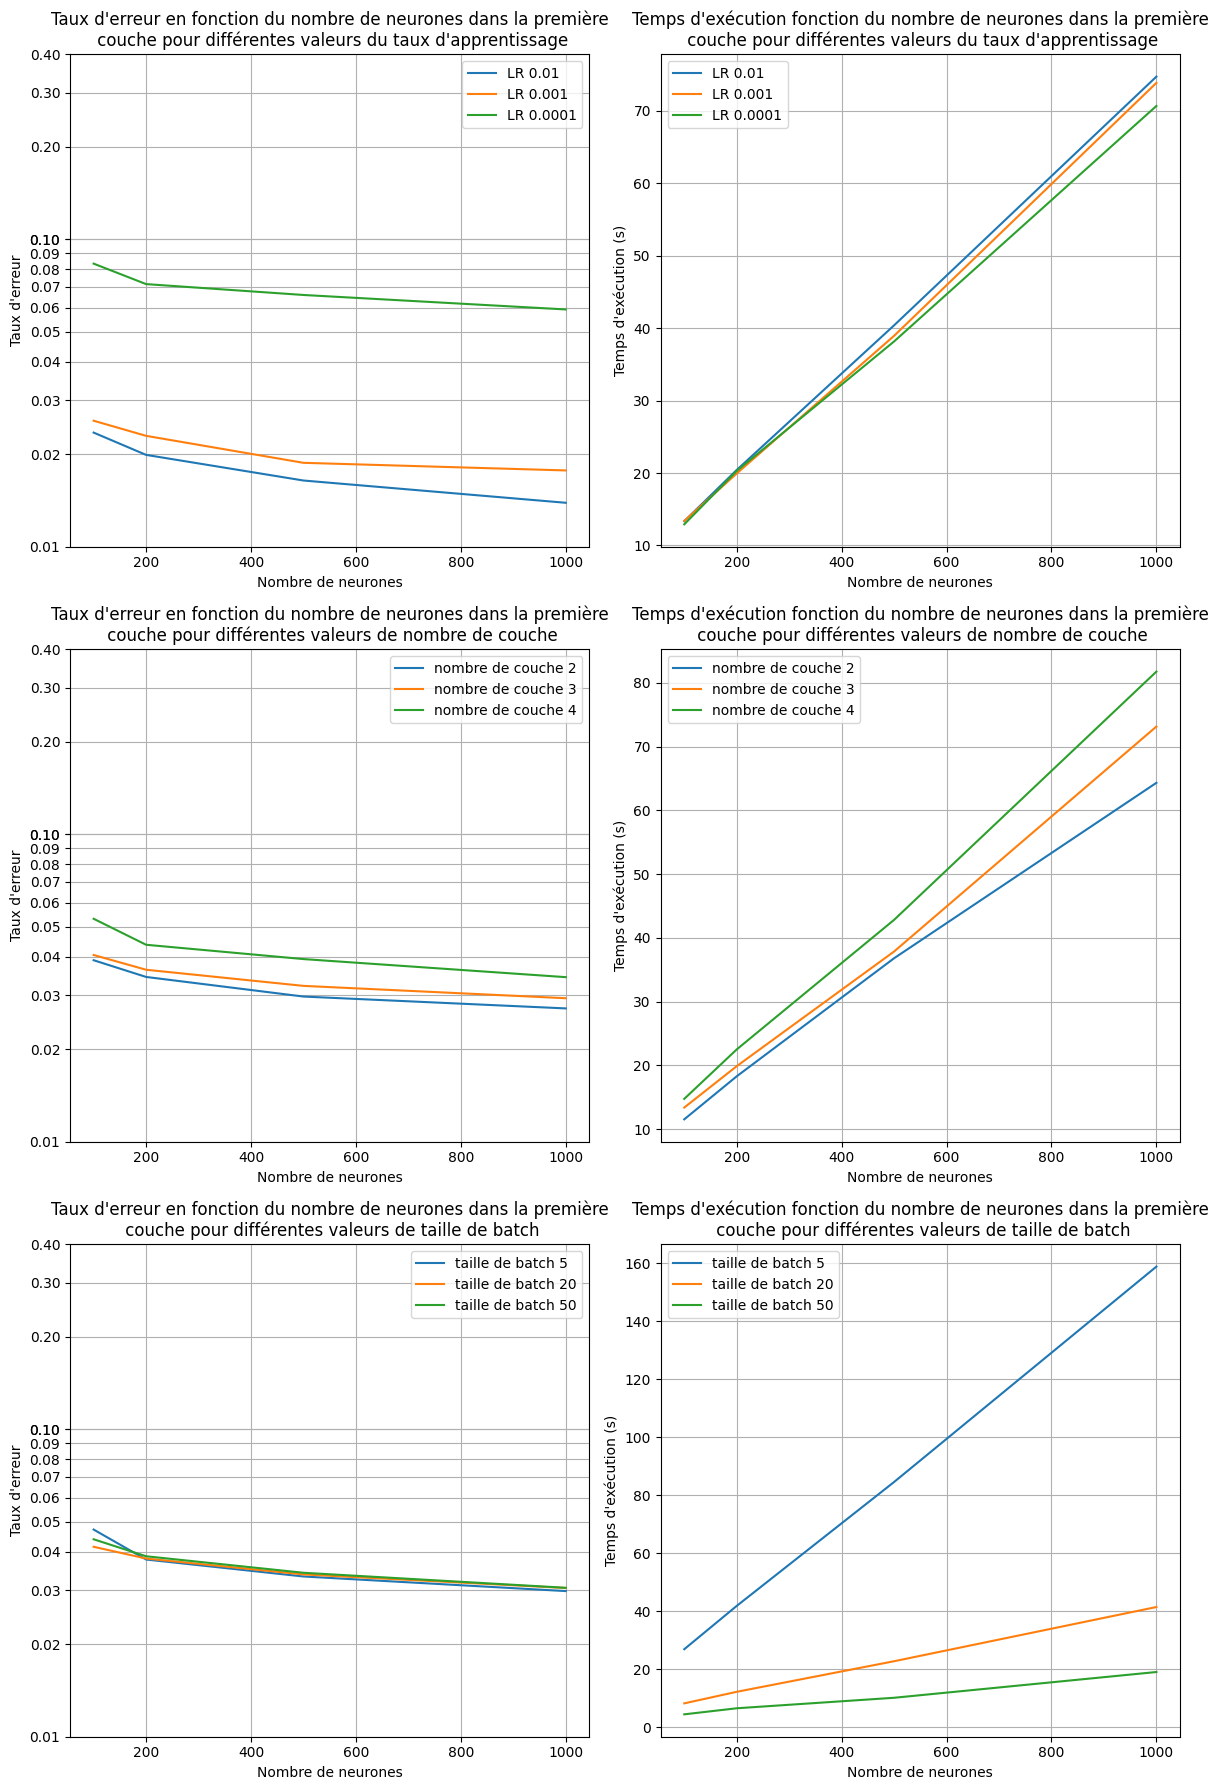

In [52]:
# Lire les données CSV
data = pd.read_csv('results_deep_first_layer_size.csv')

# Séparer les données en fonction du taux d'apprentissage
learning_rates = data['learning_rate'].unique()
numbers_of_layers = data['number_of_layers'].unique()
batch_sizes = data['batch_size'].unique()

# Créer une figure avec deux sous-graphiques
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 18))

# Parcourir les taux d'apprentissage et créer les graphiques
for lr in learning_rates:
    subset = data[data['learning_rate'] == lr].groupby("first_layer_size").mean()
    ax1.plot(subset.index, 1-subset['resultat'], label=f'LR {lr}')
    ax1.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs du taux d'apprentissage")
    ax2.plot(subset.index, subset['temps'], label=f'LR {lr}')
    ax2.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs du taux d'apprentissage")

for n in numbers_of_layers:
    subset = data[data['number_of_layers'] == n].groupby("first_layer_size").mean()
    ax3.plot(subset.index, 1-subset['resultat'], label=f'nombre de couche {n}')
    ax3.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs de nombre de couche")
    ax4.plot(subset.index, subset['temps'], label=f'nombre de couche {n}')
    ax4.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs de nombre de couche")

for bs in batch_sizes:
    subset = data[data['batch_size'] == bs].groupby("first_layer_size").mean()
    ax5.plot(subset.index, 1-subset['resultat'], label=f'taille de batch {bs}')
    ax5.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs de taille de batch")
    ax6.plot(subset.index, subset['temps'], label=f'taille de batch {bs}')
    ax6.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs de taille de batch")

for ax_x in [ax1,ax3,ax5]:
    # Configurer le premier graphique (Résultats)
    ax_x.set_xlabel('Nombre de neurones')
    ax_x.set_ylabel('Taux d\'erreur')
    ax_x.set_yscale("log")
    yticks = [0.01 * i for i in range(1, 11)] + [0.1 * i for i in range(1, 5)]
    ax_x.set_yticks(yticks)
    ax_x.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_x.legend()
    ax_x.grid(True)

for ax_y in [ax2,ax4,ax6] :
    # Configurer le deuxième graphique (Temps d'exécution)
    ax_y.set_xlabel('Nombre de neurones')
    ax_y.set_ylabel('Temps d\'exécution (s)')
    ax_y.legend()
    ax_y.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

Cependant nous avons remarqué qu'il y avait un certain applatissement des différences du à certains hyper-paramètres moins bon que d'autres pour lesquels il y a moins de différences. Ainsi pour avoir plus de différences quite à perdre la stabilité statistique lié à la moyenne, nous avons décidé d'un ensemble de paramètres qui nous semblait être le meilleur compromis entre temps d'execution et performances et pour chaque graphique si l'hyper paramètres n'est pas apparent alors la valeur par défaut est utilisé.
- $\eta = 0.01$
- $N_C = 2$
- $batch\_size = 20$

On obtient alors les graphiques ci-dessous :

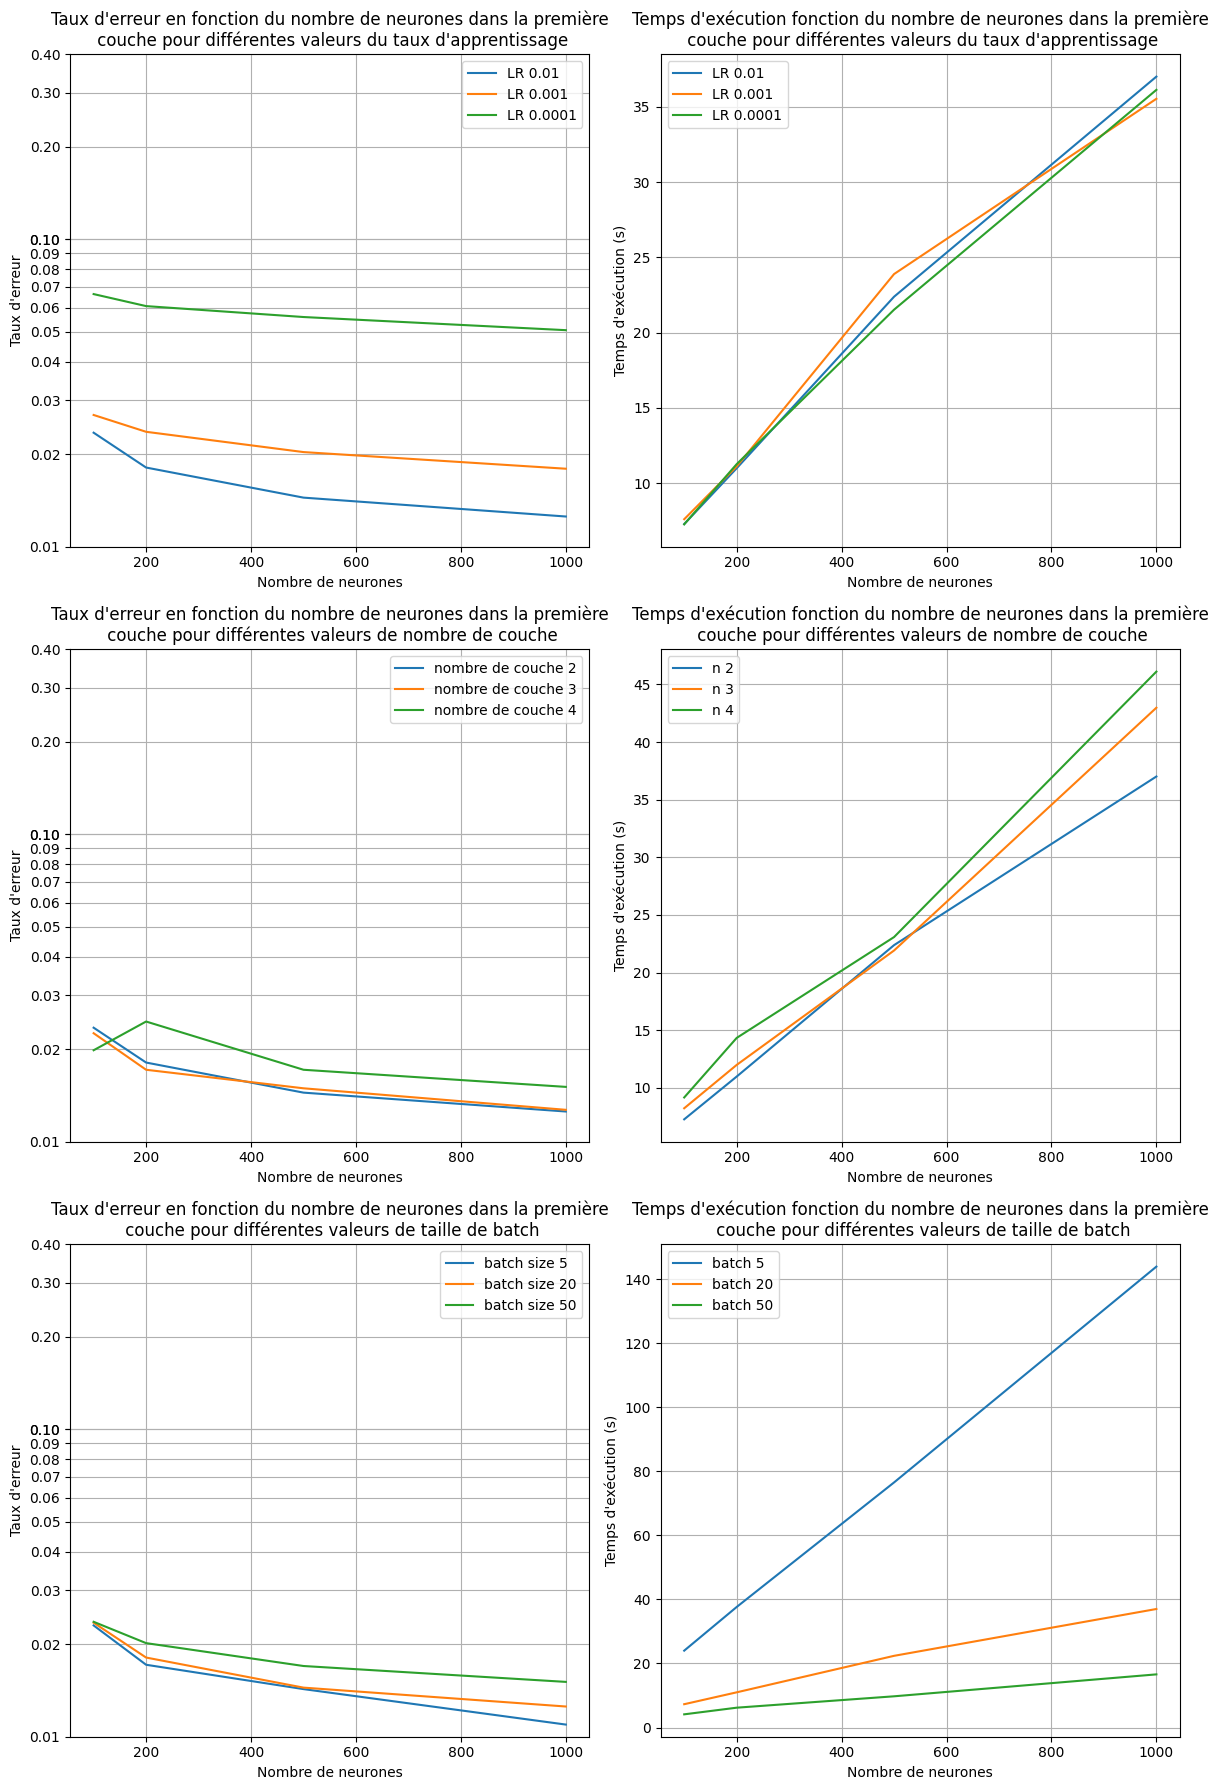

In [56]:
# Lire les données CSV
data = pd.read_csv('results_deep_first_layer_size.csv')

# Séparer les données en fonction du taux d'apprentissage
learning_rates = data['learning_rate'].unique()
numbers_of_layers = data['number_of_layers'].unique()
batch_sizes = data['batch_size'].unique()

default_learning_rates = data['learning_rate'] == 0.01
default_number_of_layers = data['number_of_layers'] == 2
default_batch_size = data['batch_size'] == 20

# Créer une figure avec deux sous-graphiques
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 18))

# Parcourir les taux d'apprentissage et créer les graphiques
for lr in learning_rates:
    subset = data[(data['learning_rate'] == lr) & default_number_of_layers & default_batch_size]
    ax1.plot(subset["first_layer_size"], 1-subset['resultat'], label=f'LR {lr}')
    ax1.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs du taux d'apprentissage")
    ax2.plot(subset["first_layer_size"], subset['temps'], label=f'LR {lr}')
    ax2.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs du taux d'apprentissage")

for n in numbers_of_layers:
    subset = data[default_learning_rates & (data['number_of_layers'] == n) & default_batch_size]
    ax3.plot(subset["first_layer_size"], 1-subset['resultat'], label=f'nombre de couche {n}')
    ax3.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs de nombre de couche")
    ax4.plot(subset["first_layer_size"], subset['temps'], label=f'n {n}')
    ax4.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs de nombre de couche")

for bs in batch_sizes:
    subset = data[default_learning_rates & default_number_of_layers & (data['batch_size'] == bs)]
    ax5.plot(subset["first_layer_size"], 1-subset['resultat'], label=f'batch size {bs}')
    ax5.set_title("Taux d'erreur en fonction du nombre de neurones dans la première\n couche pour différentes valeurs de taille de batch")
    ax6.plot(subset["first_layer_size"], subset['temps'], label=f'batch {bs}')
    ax6.set_title("Temps d'exécution fonction du nombre de neurones dans la première\n couche pour différentes valeurs de taille de batch")

for ax_x in [ax1,ax3,ax5]:
    # Configurer le premier graphique (Résultats)
    ax_x.set_xlabel('Nombre de neurones')
    ax_x.set_ylabel('Taux d\'erreur')
    ax_x.set_yscale("log")
    yticks = [0.01 * i for i in range(1, 11)] + [0.1 * i for i in range(1, 5)]
    ax_x.set_yticks(yticks)
    ax_x.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax_x.legend()
    ax_x.grid(True)

for ax_y in [ax2,ax4,ax6] :
    # Configurer le deuxième graphique (Temps d'exécution)
    ax_y.set_xlabel('Nombre de neurones')
    ax_y.set_ylabel('Temps d\'exécution (s)')
    ax_y.legend()
    ax_y.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

## Partie 4 : CNN

L'objectif est d'implémenter un réseau de neurones convolutif.

### Méthodologie

```python
class LeNet5(nn.Module):
	def __init__(self):
		super().__init__()
		self.layer1 = nn.Sequential(
			nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
			nn.BatchNorm2d(6),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size = 2, stride = 2))
		self.layer2 = nn.Sequential(
			nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size = 2, stride = 2))
		self.linear1 = nn.Linear(400, 120)
		nn.init.uniform_(self.linear1.weight, -0.001, 0.001)
		self.linear2 = nn.Linear(120, 84)
		nn.init.uniform_(self.linear2.weight, -0.001, 0.001)
		self.linear3 = nn.Linear(84, 10)
		nn.init.uniform_(self.linear3.weight, -0.001, 0.001)
		
	def forward(self, x):
		x = x.view(x.size(0),1,28,28)
		x = self.layer1(x)
		x = self.layer2(x)
		x = x.reshape(x.size(0), -1)
		x = self.linear1(x)
		x = F.relu(x)
		x = self.linear2(x)
		x = F.relu(x)
		x = self.linear3(x)
		return x
```

L'architecture du réseau est inspirée de celle donnée dans [Lecun](https://hal.science/hal-03926082/document).  
La `layer1` exécute la 1ère convolution(`nn.Conv2d`), elle prend en entré un tensor de dimension $(batch\_size, 1, 28, 28)$, le kernel étant de taille 5, cette convolution nécessitait un padding de 2 pour conserver en sortie des matrices de dimension $(28,28)$. Ensuite, `nn.MaxPool2d` applique le subsampling de matrices de $(28,28)$ à des matrices de $(14,14)$.  
La `layer2` exécute la 2ème convolution prenant les matrices précédentes pour sortir 16 matrices de $(10,10)$. Le subsampling suivant transforme les matrices en dimension $(5,5)$.  
Ensuite, des couches similaires au perceptron multi-couches permettent de réduire les résultats en un vecteur de 10 valeurs en faisant succéder une couche linéaire, d'une relu, linéaire, relu et enfin linéaire.

Résultats (à gauche l'accuracy sur le batch de test et à droite le temps d'exécution accumulé en secondes) :
> Sur mon ordinateur
```python
tensor([0.1996]) 50.06423878669739
tensor([0.9476]) 98.38135719299316
tensor([0.9780]) 149.69705057144165
tensor([0.9816]) 215.07379031181335
tensor([0.9851]) 268.4216022491455
tensor([0.9834]) 325.4106557369232
tensor([0.9863]) 376.84096574783325
tensor([0.9850]) 429.86590003967285
tensor([0.9847]) 481.203097820282
tensor([0.9841]) 532.2355885505676
```
> Sur kaggle
```python
tensor([0.4809]) 48.37343430519104
tensor([0.9669]) 94.88335609436035
tensor([0.9789]) 140.88308835029602
tensor([0.9854]) 187.28817486763
tensor([0.9830]) 232.813392162323
tensor([0.9854]) 278.8786988258362
tensor([0.9873]) 324.19943380355835
tensor([0.9873]) 369.5354652404785
tensor([0.9867]) 415.27380990982056
tensor([0.9857]) 461.0540907382965

```